In [2]:
import glob
import itertools
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import os
import pandas as pd
import pickle
import re
import scanpy as sc
import scipy
import seaborn as sns
#import signatureanalyzer as sa
import sklearn
import statsmodels
import sys

from adjustText import adjust_text
import matplotlib.gridspec as grid_spec
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.neighbors import KernelDensity
from statsmodels.stats.multicomp import pairwise_tukeyhsd

#local import
import helper_functions

In [3]:
sc.settings.verbosity = 0            # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, facecolor='white', format='png', dpi_save=180)#, figsize=[7,7])
fig_dir = 'figures/script5b/'
sc.settings.figdir = fig_dir
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

# Read in QCd/cleaned CD138+ anndata object

In [4]:
cd138_adata = sc.read('outputs/script5_MOREHVG/cd138_adata_MOREHVG_noIG.h5ad')
cd138_adata

AnnData object with n_obs × n_vars = 29387 × 22273
    obs: 'person', 'age', 'sorting_tag', 'disease_stage', 'sex', 'disease_stage_short', 'SAMPLE', 'sample_id', 'Type', 'Gender', 'Age at Dx', 'Diagnosis date', 'Race', 'Type.1', 'FISH 1', 'FISH 1 Date', 'FISH 2', 'FISH 2 Date', 'FISH 3', 'FISH 3 Date', 'FISH 4', 'FISH 4 Date', 'BM at Diagnosis', 'M Protein when sample was taken', 'Date of BM Aspirate used for single-cell RNA Seq', 'Infiltration of Used BM or Aspirate', 'BM Transplant', 'Transplant Date', 'Induction', 'XRT', 'Maintenance Tx', 'Relapse Date', 'Total # cells', 'CD138+', 'CD45+', 'CD45-', 'PMH', 'Family Hx', 'Smoking', 'Alcohol', 'Previous Chemo', 'n_genes', 'percent_mito', 'n_counts', 'possible_doublet', 'S_score', 'G2M_score', 'phase', 'prolif_idx', 'EMT_score', 'leiden', '__is_in_cluster__', 'ground_truth', 'ncells_persample', 'hemoglobin_score', 'person_group', 'sample_purity', 'person_oldnames', 'tx', 'HRD', 'driver event', 'driver_event_specific', 'batch', 'vial', 'W

In [5]:
# IG genes, which are variable because of known disease type and separate patients from each other
ig_genes = pd.read_csv("data/Ig_locus_genes.txt", header=None).iloc[:,0].tolist()

# hemoglobin genes -- likely contamination
r = re.compile("^HB.*")
hemoglobin_genes = list(filter(r.match, cd138_adata.var.highly_variable.index))
#by manual inspection, not all of these are hemoglobin genes, remove those
hemoglobin_genes.remove("HBEGF")
hemoglobin_genes.remove("HBS1L")
hemoglobin_genes.remove("HBP1")

# ribosomal proteins
r = re.compile("^RP.*")
rp_genes = list(filter(r.match, cd138_adata.var.highly_variable.index))

#sex genes
sex_genes = ['XIST', 'RPS4Y1']

#immune genes
immune_genes = ['PTPRC', 'LILRA4', 'CD14', 'FCER1A', 'MPO', 'CD34', 'CD3D', 'KLRC1','FCGR3A', 'CD1C','IGLL1', 'MS4A1', 'CD68', 'IL7R', 'NKG7', 'LYZ']
lightchain_genes = ['IGKC', 'IGLC2', 'IGLC7']
heavychain_genes = ['IGHG4','IGHG2','IGHGP','IGHG1','IGHG3','IGHA1','IGHA2','IGHE','IGHM','IGHD']

# Read in Signatures

In [7]:
Sidx = cd138_adata.obs.columns[cd138_adata.obs.columns.str.match('W\d+')]

In [11]:
signatures_desc = pd.read_csv("outputs/script5_MOREHVG/signaturesdesc_MOREGENES_noIG_run93.csv", index_col=0)

In [12]:
signatures_desc.loc['W20','desc']="protein synthesis"
signatures_desc

,desc,type,top_genes
signature,,,
W1,NaN,NaN,"['JUNB', 'ZFP36', 'NFKBIA', 'IER2']"
W2,MM-1,patient specific,"['MTDH', 'HLA-A', 'IFI27', 'SNHG25']"
W3,CCND1 (t(11;14) associated),NaN,"['CCND1', 'TSC22D3', 'RP5-887A10.1', 'RGS13']"
W4,HLA class II,NaN,"['HLA-DRA', 'HLA-DRB1', 'HLA-DPA1', 'HLA-DPB1']"
W5,histones,NaN,"['HIST1H1C', 'HIST1H2AC', 'HIST1H2BC', 'KIAA05..."
W6,NaN,NaN,"['DUSP4', 'GADD45A', 'BTG2', 'LAMP5']"
W7,MM-4,patient specific,"['IFI6', 'PTP4A3', 'HLA-A', 'LAG3']"
W8,"ITGB7, MAFB, CCND2 (t(14;20) associated)",NaN,"['ITGB7', 'AC233755.2', 'SPP1', 'CCND2']"
W9,extracellular signaling,NaN,"['LGALS1', 'VIM', 'ACTB', 'S100A6']"


In [254]:
W=pd.read_csv('~/GitHub/SignatureAnalyzer-GPU-rpeys/cd138_moreHVG_rmIGproperly/results/nmf_results_3754HVG_take93_W.txt', sep="\t", index_col=0) 
H=pd.read_csv('~/GitHub/SignatureAnalyzer-GPU-rpeys/cd138_moreHVG_rmIGproperly/results/nmf_results_3754HVG_take93_H.txt', sep="\t", index_col=0)

In [255]:
H=H.T

In [256]:
H = H.divide(cd138_adata.obs.loc[H.index,:].n_counts, axis=0)*10000 #divide each cell by total counts, multiply by 10k

In [257]:
UE = W[Sidx]*H[Sidx].sum() #total activity for this gene, from this signature (multiply gene activity in signature by the sum of cellular activity from this signature)
FE = (UE.T/UE.T.sum()).T #how much of the genes' activity comes from this signature (specificity of gene to signature)

R=W[Sidx]*FE[Sidx]

R['max'] = R[Sidx].max(axis=1)
R['max_id'] = np.argmax(R[Sidx].values,axis=1)+1

# Characterize Signature Heterogeneity Among Tumor Cells

NBM-1
NBM-2
NBM-3
NBM-4
NBM-6
NBM-7
NBM-8
NBM-10
NBM-11
MGUS-1
MGUS-2


/opt/conda/rpeyser/envs/mm_singlecell_v2/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/opt/conda/rpeyser/envs/mm_singlecell_v2/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:752: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)




MGUS-3


/opt/conda/rpeyser/envs/mm_singlecell_v2/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/opt/conda/rpeyser/envs/mm_singlecell_v2/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:752: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)




MGUS-4
MGUS-5
MGUS-6


/opt/conda/rpeyser/envs/mm_singlecell_v2/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/opt/conda/rpeyser/envs/mm_singlecell_v2/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:752: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)




SMM-1


/opt/conda/rpeyser/envs/mm_singlecell_v2/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/opt/conda/rpeyser/envs/mm_singlecell_v2/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:752: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)




SMM-2


/opt/conda/rpeyser/envs/mm_singlecell_v2/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/opt/conda/rpeyser/envs/mm_singlecell_v2/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:752: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)




SMM-3


/opt/conda/rpeyser/envs/mm_singlecell_v2/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)




SMM-4


/opt/conda/rpeyser/envs/mm_singlecell_v2/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/opt/conda/rpeyser/envs/mm_singlecell_v2/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:752: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)




SMM-5


/opt/conda/rpeyser/envs/mm_singlecell_v2/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/opt/conda/rpeyser/envs/mm_singlecell_v2/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:752: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)




SMM-6


/opt/conda/rpeyser/envs/mm_singlecell_v2/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/opt/conda/rpeyser/envs/mm_singlecell_v2/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:752: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)




SMM-7


/opt/conda/rpeyser/envs/mm_singlecell_v2/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/opt/conda/rpeyser/envs/mm_singlecell_v2/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:752: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)




SMM-8


/opt/conda/rpeyser/envs/mm_singlecell_v2/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/opt/conda/rpeyser/envs/mm_singlecell_v2/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:752: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)




SMM-9


/opt/conda/rpeyser/envs/mm_singlecell_v2/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/opt/conda/rpeyser/envs/mm_singlecell_v2/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:752: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)




SMM-10


/opt/conda/rpeyser/envs/mm_singlecell_v2/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/opt/conda/rpeyser/envs/mm_singlecell_v2/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:752: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)




SMM-11


/opt/conda/rpeyser/envs/mm_singlecell_v2/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/opt/conda/rpeyser/envs/mm_singlecell_v2/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:752: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)




SMM-12


/opt/conda/rpeyser/envs/mm_singlecell_v2/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/opt/conda/rpeyser/envs/mm_singlecell_v2/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:752: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)




MM-1


/opt/conda/rpeyser/envs/mm_singlecell_v2/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/opt/conda/rpeyser/envs/mm_singlecell_v2/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:752: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)




MM-2


/opt/conda/rpeyser/envs/mm_singlecell_v2/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)




MM-3


/opt/conda/rpeyser/envs/mm_singlecell_v2/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)




MM-4


/opt/conda/rpeyser/envs/mm_singlecell_v2/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/opt/conda/rpeyser/envs/mm_singlecell_v2/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:752: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)




MM-5


/opt/conda/rpeyser/envs/mm_singlecell_v2/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/opt/conda/rpeyser/envs/mm_singlecell_v2/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:752: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)




MM-6


/opt/conda/rpeyser/envs/mm_singlecell_v2/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)




MM-7


/opt/conda/rpeyser/envs/mm_singlecell_v2/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/opt/conda/rpeyser/envs/mm_singlecell_v2/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:752: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)




MM-8


/opt/conda/rpeyser/envs/mm_singlecell_v2/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/opt/conda/rpeyser/envs/mm_singlecell_v2/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:752: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


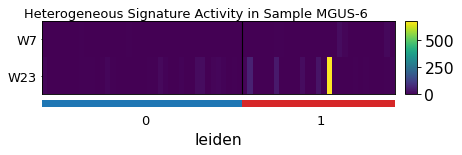

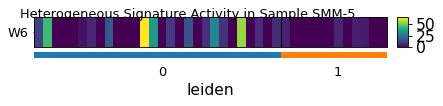

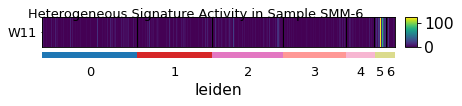

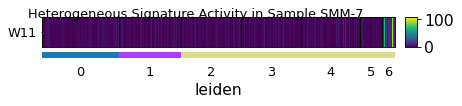

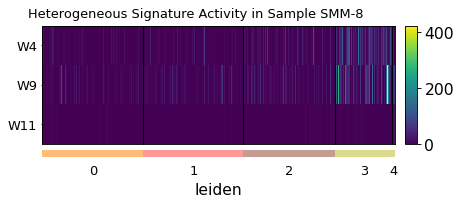

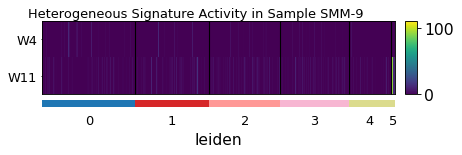

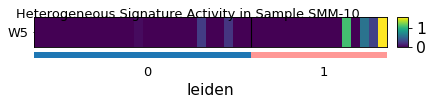

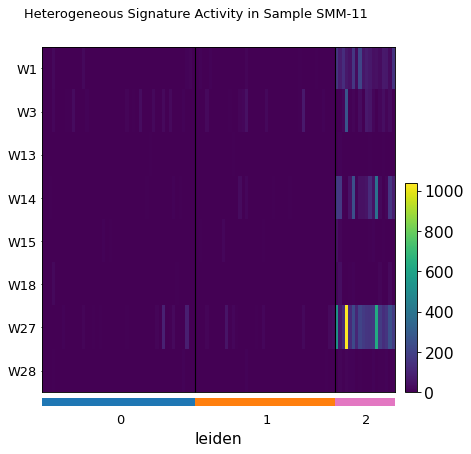

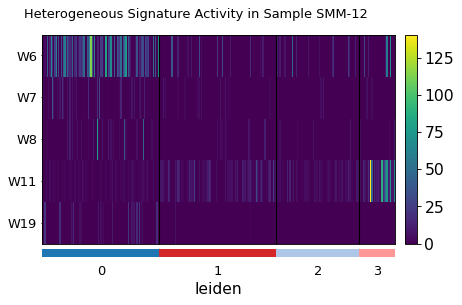

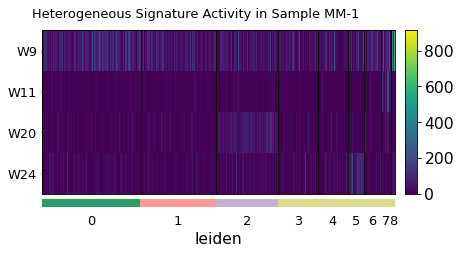

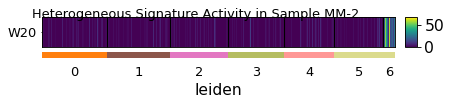

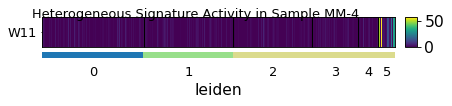

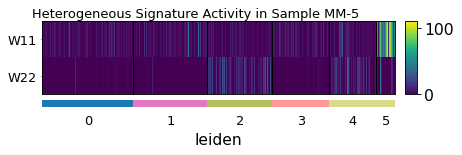

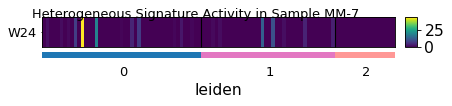

In [283]:
#only looking at malignant cells
high_var_samples=[]
high_var_sigs=[]
high_var_descs=[]
for person in cd138_adata.obs.person.drop_duplicates().sort_values():
    print(person)
    person_adata = cd138_adata[(cd138_adata.obs.person.isin([person]))&(cd138_adata.obs.ground_truth=="malignant"),:].copy()
    if len(person_adata)<5:
        continue
    person_adata.obs['leiden_orig'] = person_adata.obs.leiden
    sc.pp.highly_variable_genes(person_adata, layer="lognorm", min_mean=0.0125, max_mean=3, min_disp=0.6)
    person_adata.var.highly_variable.loc[person_adata.var.index.isin(ig_genes)] = False
    sc.pp.scale(person_adata, max_value=10)
    sc.tl.pca(person_adata, svd_solver='arpack')
    pcs_to_keep = 10
    sc.pp.neighbors(person_adata, n_neighbors=15, n_pcs=pcs_to_keep)
    sc.tl.umap(person_adata)
    sc.tl.leiden(person_adata, resolution = 0.6)
    tmp=person_adata.obs[['person','leiden']+list(Sidx)].groupby(['person','leiden']).mean() #average signature activity in each cluster
    cv_bw_clusters = tmp.std(axis=0)/tmp.mean(axis=0)
    this_high_var_sigs = cv_bw_clusters[cv_bw_clusters>1].index.tolist() #signatures with high variance between clusters
    if len(this_high_var_sigs)>0:

        sc.pl.heatmap(person_adata, var_names=this_high_var_sigs, groupby="leiden", swap_axes=True, 
              figsize=[6,len(this_high_var_sigs)*0.75],
              show=False
             )
        plt.suptitle("Heterogeneous Signature Activity in Sample {}".format(person), size="small")
        plt.savefig("figures/script5b/heatmap_{}_highvarsigs_sampleclusters.png".format(person), bbox_inches="tight")
        sc.pl.umap(person_adata, color=this_high_var_sigs, ncols=2,
               title=signatures_desc.loc[this_high_var_sigs,'desc'].index.astype('str') +": "+ signatures_desc.loc[this_high_var_sigs,'desc'].astype('str'),
               save="_automated_heterogeneity_"+person+".pdf"
              )
        high_var_sigs+=this_high_var_sigs
        high_var_samples+=[person for i in np.arange(len(this_high_var_sigs))]
        high_var_descs+=signatures_desc.loc[this_high_var_sigs,'desc'].astype('str').tolist()

    print("\n")

In [237]:
heterogeneity_results = pd.DataFrame({"sigs":high_var_sigs,"samples":high_var_samples,'desc':high_var_descs})

In [244]:
heterogeneity_results

,sigs,samples,desc
0,W11,MM-5,proliferation
1,W22,MM-5,TMSB4X
2,W6,SMM-12,nan
3,W7,SMM-12,MM-4
4,W8,SMM-12,"ITGB7, MAFB, CCND2 (t(14;20) associated)"
5,W11,SMM-12,proliferation
6,W19,SMM-12,SMMh-4
7,W1,SMM-11,nan
8,W3,SMM-11,CCND1 (t(11;14) associated)
9,W13,SMM-11,FOS


In [243]:
heterogeneity_results.groupby('sigs').size().sort_values()

sigs
W1     1
W5     1
W3     1
W28    1
W27    1
W8     1
W22    1
W23    1
W19    1
W18    1
W15    1
W14    1
W13    1
W24    2
W4     2
W6     2
W7     2
W20    2
W9     2
W11    8
dtype: int64

## Create plots of top genes on signature for sample/signature pairs of interest (Extended Data Fig)

MM-1


/opt/conda/rpeyser/envs/mm_singlecell_v2/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/opt/conda/rpeyser/envs/mm_singlecell_v2/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:752: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


MM-4


/opt/conda/rpeyser/envs/mm_singlecell_v2/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/opt/conda/rpeyser/envs/mm_singlecell_v2/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:752: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


MM-5


/opt/conda/rpeyser/envs/mm_singlecell_v2/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/opt/conda/rpeyser/envs/mm_singlecell_v2/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:752: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


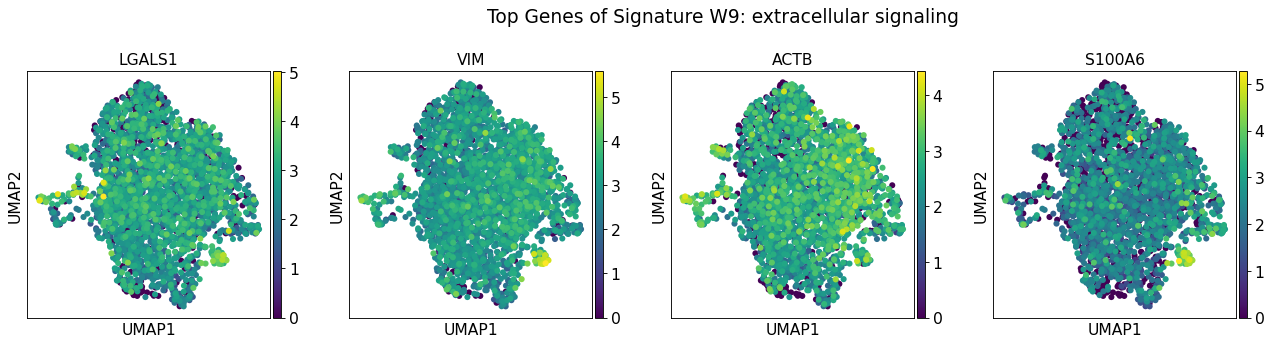

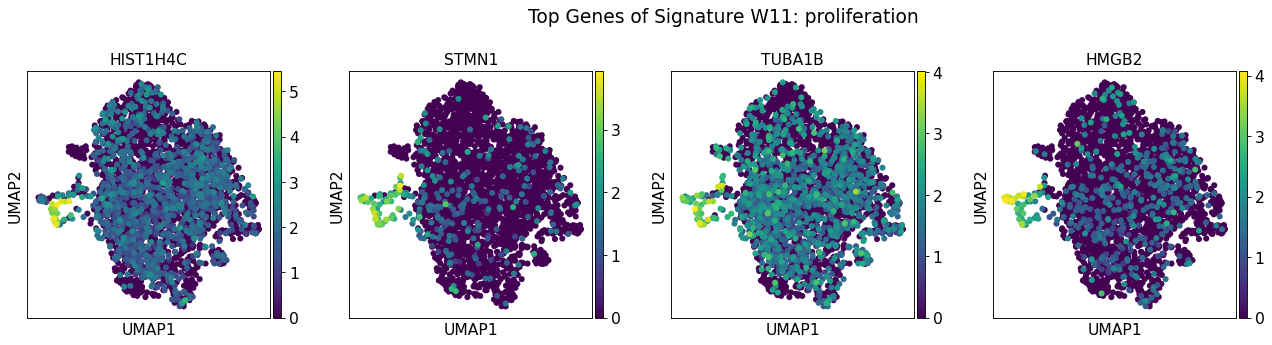

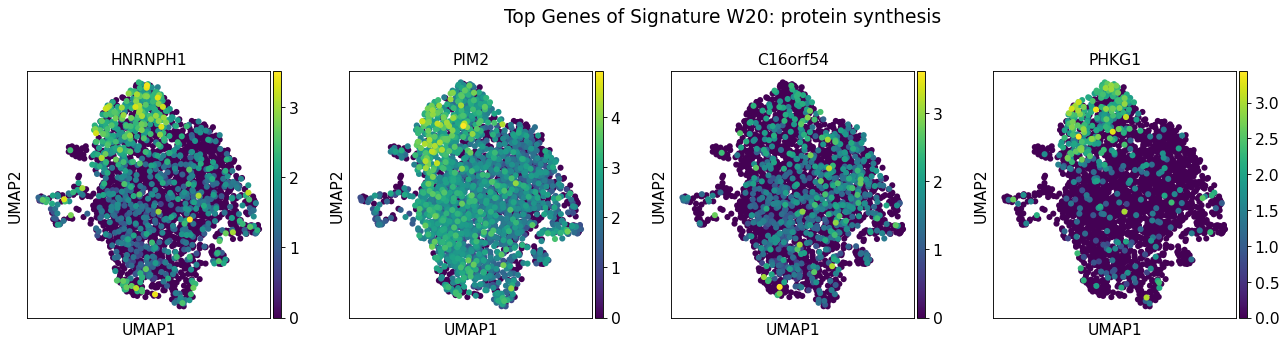

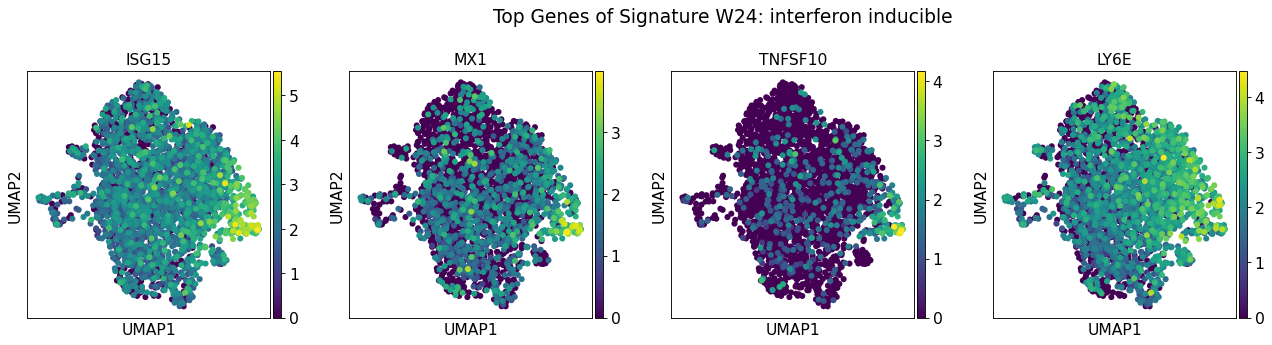

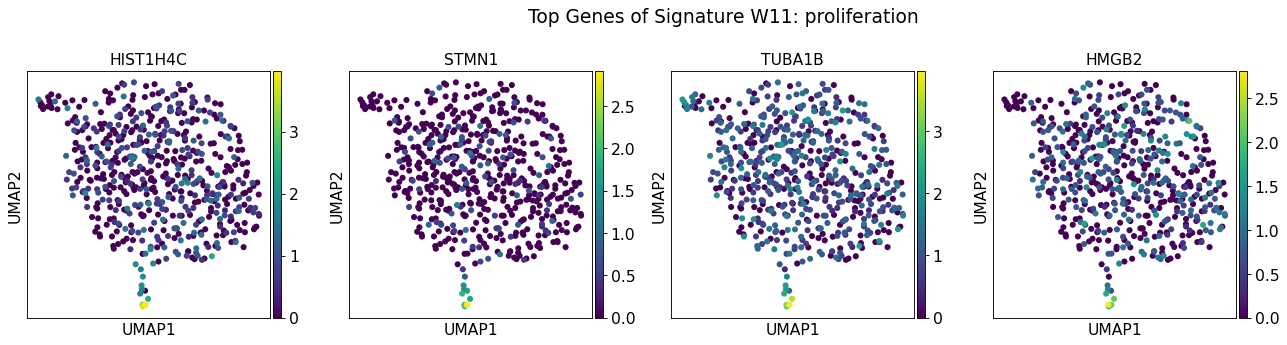

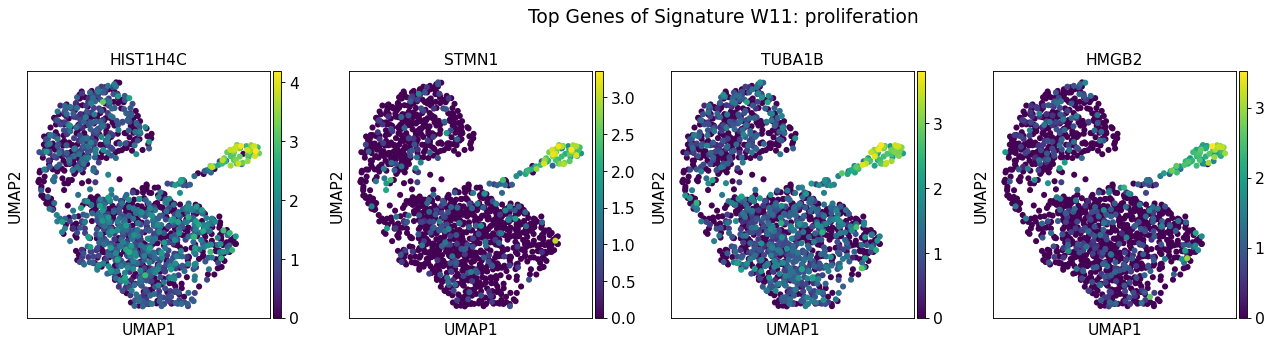

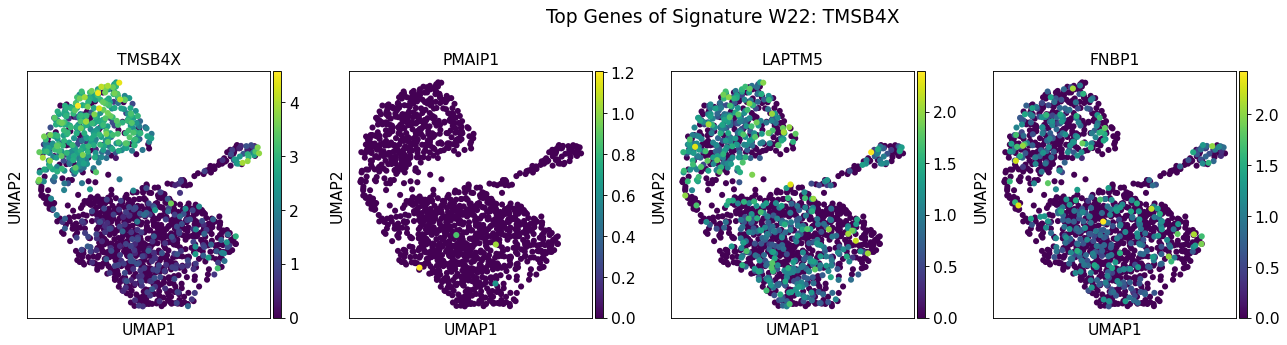

In [258]:
for person in ["MM-1","MM-4","MM-5"]:
    print(person)
    person_adata = cd138_adata[(cd138_adata.obs.person.isin([person]))&(cd138_adata.obs.ground_truth=="malignant"),:].copy()
    person_adata.obs['leiden_orig'] = person_adata.obs.leiden
    sc.pp.highly_variable_genes(person_adata, layer="lognorm", min_mean=0.0125, max_mean=3, min_disp=0.6)
    person_adata.var.highly_variable.loc[person_adata.var.index.isin(ig_genes)] = False
    sc.pp.scale(person_adata, max_value=10)
    sc.tl.pca(person_adata, svd_solver='arpack')
    pcs_to_keep = 10
    sc.pp.neighbors(person_adata, n_neighbors=15, n_pcs=pcs_to_keep)
    sc.tl.umap(person_adata)
    sc.tl.leiden(person_adata, resolution = 0.6)
    tmp=person_adata.obs[['person','leiden']+list(Sidx)].groupby(['person','leiden']).mean() #average signature activity in each cluster
    cv_bw_clusters = tmp.std(axis=0)/tmp.mean(axis=0)
    this_high_var_sigs = cv_bw_clusters[cv_bw_clusters>1].index.tolist() #signatures with high variance between clusters
    for sig in this_high_var_sigs:
        genes_to_plot=R.sort_values(by=sig, ascending=False)[:4].index
        sc.pl.umap(person_adata, color=genes_to_plot,size=120,ncols=4,show=False)        
        plt.suptitle("Top Genes of Signature {}".format(sig+": "+signatures_desc.loc[sig,'desc']),y=1.1)      
        plt.savefig("figures/script5b/umap_heterogeneity_{}_genes_{}.pdf".format(person,sig), bbox_inches="tight")
print("\n")

## for review, experimenting with resolution parameter

/opt/conda/rpeyser/envs/mm_singlecell_v2/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/opt/conda/rpeyser/envs/mm_singlecell_v2/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:752: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


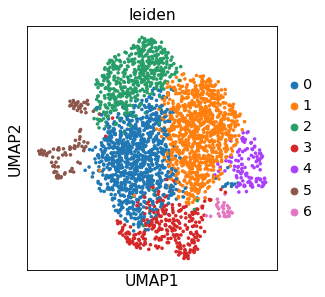

In [267]:
person="MM-1"
res=0.3

person_adata = cd138_adata[(cd138_adata.obs.person.isin([person]))&(cd138_adata.obs.ground_truth=="malignant"),:].copy()
person_adata.obs['leiden_orig'] = person_adata.obs.leiden
sc.pp.highly_variable_genes(person_adata, layer="lognorm", min_mean=0.0125, max_mean=3, min_disp=0.6)
person_adata.var.highly_variable.loc[person_adata.var.index.isin(ig_genes)] = False
sc.pp.scale(person_adata, max_value=10)
sc.tl.pca(person_adata, svd_solver='arpack')
pcs_to_keep = 10
sc.pp.neighbors(person_adata, n_neighbors=15, n_pcs=pcs_to_keep)
sc.tl.umap(person_adata)
sc.tl.leiden(person_adata, resolution = res)
sc.pl.umap(person_adata, color="leiden")
